In [1]:
import numpy as np
import pygrib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas as pd
import time
import xarray as xr

/home/mmfire/anaconda3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/mmfire/anaconda3/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [37]:
temp_ave = np.zeros((15,161,291))
temp_ave = np.ma.masked_array(temp_ave)
prcp_ave = np.zeros((15,161,291))
prcp_ave = np.ma.masked_array(prcp_ave)

for yl in range(15):
    temp_year = pygrib.open('./alaska_data/temp_{0}.grib'.format((2002+yl))) 
    prcp_year = pygrib.open('./alaska_data/prcp_{0}.grib'.format((2002+yl))) 
    n = temp_year.messages
    temp = np.zeros((n,161,291))
    temp = np.ma.masked_array(temp)
    prcp = np.zeros((int(np.array([i for i in range(9,n,8)]).shape[0]),161,291))
    prcp = np.ma.masked_array(prcp)
    for i in range(1,n+1):
        temp[i-1,:,:] = temp_year.message(i).values
        
    for i in range(9,n,8):
        prcp[int((i-9)/8),:,:] = prcp_year.message(i).values
        
    temp_ave[yl,:,:] = temp.mean(axis=0)
    prcp_ave[yl,:,:] = prcp.mean(axis=0)
    
    temp_year.close()
    prcp_year.close()


In [43]:
temp_ave = xr.DataArray(temp_ave)
temp_ave.name = 'temp'  
temp_ave.to_netcdf('./alaska_data/EOF/temp_annual_mean.nc')
prcp_ave = xr.DataArray(prcp_ave)
prcp_ave.name = 'prcp'  
prcp_ave.to_netcdf('./alaska_data/EOF/prcp_annual_mean.nc')

In [45]:
vpd_ave = np.zeros((15,161,291))
vpd_ave = np.ma.masked_array(vpd_ave)

for yl in range(15):
    ds = xr.open_dataset('./alaska_data/VPD/vpd_{0}.nc'.format((2002+yl)))
    vpd = ds.vpd
    ds.close()
    
    vpd_ave[yl,:,:] = vpd.mean(axis=0)
    
vpd_ave = xr.DataArray(vpd_ave)
vpd_ave.name = 'vpd'  
vpd_ave.to_netcdf('./alaska_data/EOF/vpd_annual_mean.nc')

/home/mmfire/anaconda3/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [38]:
temp_mon = np.zeros((12*15,161,291))
temp_mon = np.ma.masked_array(temp_mon)
prcp_mon = np.zeros((12*15,161,291))
prcp_mon = np.ma.masked_array(prcp_mon)

mondays = np.array([0,31,28,31,30,31,30,31,31,30,31,30,31])
mondays = mondays.cumsum()
mondays_l = np.array([0,31,29,31,30,31,30,31,31,30,31,30,31])
mondays_l = mondays_l.cumsum()
for yl in range(15):
    temp_year = pygrib.open('./alaska_data/temp_{0}.grib'.format((2002+yl))) 
    prcp_year = pygrib.open('./alaska_data/prcp_{0}.grib'.format((2002+yl))) 
    n = temp_year.messages
    temp = np.zeros((n,161,291))
    temp = np.ma.masked_array(temp)
    prcp = np.zeros((int(np.array([i for i in range(9,n,8)]).shape[0]),161,291))
    prcp = np.ma.masked_array(prcp)
    for i in range(1,n+1):
        temp[i-1,:,:] = temp_year.message(i).values
        
    for i in range(9,n,8):
        prcp[int((i-9)/8),:,:] = prcp_year.message(i).values
        
    if (2002+yl) % 4 == 0:
        days = mondays_l
    else:
        days = mondays
    
    temp_d = np.array([temp[i*8:(i+1)*8,:,:].mean(axis=0) for i in range(days[-1])])
    temp_mon[int(yl*12):int((yl+1)*12), :, :] = np.array([temp_d[days[i]:days[i+1],:,:].mean(axis=0) for i in range(12)])
    
    days_p = days
    days_p[-1] = days_p[-1] - 1
    prcp_mon[int(yl*12):int((yl+1)*12), :, :] = np.array([prcp[days_p[i]:days_p[i+1],:,:].mean(axis=0) for i in range(12)])
    
    
    temp_year.close()
    prcp_year.close()

temp_mon = xr.DataArray(temp_mon)
temp_mon.name = 'temp'  
temp_mon.to_netcdf('./alaska_data/EOF/temp_monthly_mean.nc')
prcp_mon = xr.DataArray(prcp_mon)
prcp_mon.name = 'prcp'  
prcp_mon.to_netcdf('./alaska_data/EOF/prcp_monthly_mean.nc')

In [39]:
vpd_mon = np.zeros((12*15,161,291))
vpd_mon = np.ma.masked_array(vpd_mon)

mondays = np.array([0,31,28,31,30,31,30,31,31,30,31,30,31])
mondays = mondays.cumsum()
mondays_l = np.array([0,31,29,31,30,31,30,31,31,30,31,30,31])
mondays_l = mondays_l.cumsum()

for yl in range(15):
    ds = xr.open_dataset('./alaska_data/VPD/vpd_{0}.nc'.format((2002+yl)))
    vpd = ds.vpd.values
    ds.close()
    
    if (2002+yl) % 4 == 0:
        days = mondays_l
    else:
        days = mondays
    
    vpd_d = np.array([vpd[i*8:(i+1)*8,:,:].mean(axis=0) for i in range(days[-1])])
    vpd_mon[int(yl*12):int((yl+1)*12), :, :] = np.array([vpd[days[i]:days[i+1],:,:].mean(axis=0) for i in range(12)])
    
    
vpd_mon = xr.DataArray(vpd_mon)
vpd_mon.name = 'vpd'  
vpd_mon.to_netcdf('./alaska_data/EOF/vpd_monthly_mean.nc')

In [3]:
temp_year = pygrib.open('./alaska_data/temp_2002.grib')
grib = temp_year.message(1)
mask = grib.values.mask

In [8]:
ds = xr.open_dataset('./alaska_data/EOF/temp_monthly_mean.nc')
temp = ds.temp
ds.close()
temp1 = np.ma.masked_array(np.zeros((180,161,291)))
for i in range(180):
    temp1[i,:,:] = np.ma.masked_where(mask, temp[i,:,:])

In [11]:
temp1 = xr.DataArray(temp1)
temp1.name = 'temp'  
temp1.to_netcdf('./alaska_data/EOF/tempma_monthly_mean.nc')

In [12]:
ds = xr.open_dataset('./alaska_data/EOF/prcp_monthly_mean.nc')
prcp = ds.prcp
ds.close()
temp1 = np.ma.masked_array(np.zeros((180,161,291)))
for i in range(180):
    temp1[i,:,:] = np.ma.masked_where(mask, prcp[i,:,:])

In [13]:
temp1 = xr.DataArray(temp1)
temp1.name = 'prcp'  
temp1.to_netcdf('./alaska_data/EOF/prcpma_monthly_mean.nc')

In [21]:
prcp_mon = np.zeros((12*15,161,291))
prcp_mon = np.ma.masked_array(prcp_mon)

mondays = np.array([0,31,28,31,30,31,30,31,31,30,31,30,31])
mondays = mondays.cumsum()
mondays_l = np.array([0,31,29,31,30,31,30,31,31,30,31,30,31])
mondays_l = mondays_l.cumsum()
for yl in range(15):
    prcp_year = pygrib.open('./alaska_data/prcp_{0}.grib'.format((2002+yl))) 
    n = prcp_year.messages
    prcp = np.zeros((int(np.array([i for i in range(9,n,8)]).shape[0]),161,291))
    prcp = np.ma.masked_array(prcp)
    for i in range(9,n,8):
        prcp[int((i-9)/8),:,:] = prcp_year.message(i).values
        
    if (2002+yl) % 4 == 0:
        days = mondays_l
    else:
        days = mondays
    
    days_p = days
    days_p[-1] = days_p[-1] - 1
    prcp_mon[int(yl*12):int((yl+1)*12), :, :] = np.array([prcp[days_p[i]:days_p[i+1],:,:].sum(axis=0) for i in range(12)])
    
    prcp_year.close()

prcp_mon = xr.DataArray(prcp_mon)
prcp_mon.name = 'prcp'  
prcp_mon.to_netcdf('./alaska_data/EOF/prcp_monthly_accum.nc')

In [22]:
ds = xr.open_dataset('./alaska_data/EOF/prcp_monthly_accum.nc')
prcp = ds.prcp
ds.close()
temp1 = np.ma.masked_array(np.zeros((180,161,291)))
for i in range(180):
    temp1[i,:,:] = np.ma.masked_where(mask, prcp[i,:,:])
    
temp1 = xr.DataArray(temp1)
temp1.name = 'prcp'  
temp1.to_netcdf('./alaska_data/EOF/prcpma_monthly_accum.nc')

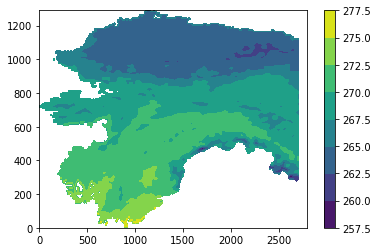

In [10]:
ds = xr.open_dataset('./alaska_data/EOF/temp_interp.nc')
temp = ds.temp.values
ds.close()
temp = temp[:,:,:].mean(axis=0)
plt.contourf(temp)
plt.colorbar()

In [7]:
# yl=0
# temp_year = pygrib.open('./alaska_data/temp_{0}.grib'.format((2002+yl)))
temp_year.message(1).data()

(masked_array(
   data=[[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]],
   mask=[[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]],
   fill_value=9999.0), array([[73. , 73. , 73. , ..., 73. , 73. , 73. ],
        [72.9, 72.9, 72.9, ..., 72.9, 72.9, 72.9],
        [72.8, 72.8, 72.8, ..., 72.8, 72.8, 72.8],
        ...,
        [57.2, 57.2, 57.2, ..., 57.2, 57.2, 57.2],
        [57.1, 57.1, 57.1, ..., 57.1, 57.1, 57.1],
        [57. , 57. , 57. , ..., 57. , 57. , 57. ]]), array([[-169. , -168.9, 